<a href="https://colab.research.google.com/github/keinam53/Deep_learning/blob/main/6_Rekurencyjne_Sieci_Neuronowe/2_Klasyfikacja_recenzji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spis treści:
1. [Import bibliotek](#a0)
2. [Załadowanie danych i wstępna eksploracja](#a1)
3. [Podział na zbiór treningowy oraz testowy](#a2)
4. [Budowa modelu](#a3)
5. [Warstwa SimpleRNN](#a4)
6. [Warstwa LSTM](#a5)
7. [Ocena modelu na zbiorze testowym](#a6)


### <a name='a0'></a> 1. Import biblotek

In [1]:
import numpy as np
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

### <a name='a1'></a> 2. Załadowanie danych i wstępna eksploracja

In [2]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/reviews.zip
!unzip -q reviews.zip

In [3]:
data_dir = './reviews'
train_dir = os.path.join(data_dir, 'train')

train_texts = []
train_labels = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            train_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)

In [4]:
test_dir = os.path.join(data_dir, 'test')

test_texts = []
test_labels = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            test_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)

In [5]:
train_texts[:3]

['So, Steve Irwin. You have to admire a man who is not only willing to throw himself into a river that clearly is filled with crocs, snakes, lizards, tons of poop from the aforementioned reptiles, and mud, not only daily, but with enthusiasm. He was never able to make ME want to do it, but he managed to make his wife come close.<br /><br />This movie does not fall into my parallel universe of film category - the films for people who just had their teeth drilled, have a migraine, or have no film experience and therefore like quiet mediocrity (currently well populated by Disney films). It\'s too noisy. Well, Steve is too noisy. He\'s just so happy all the time, and would cut right through the blasé\' teenager (I can hear it now: "that movie was so STUPID") or the Tylenol with codeine. I\'d say his enthusiasm is catching, but if it was, I would own a room full of snakes, and that hasn\'t happened yet. I agreed they\'re beauties, but I\'m still not going to pet them.<br /><br />Plot was in

In [6]:
train_labels[:3]

[0, 0, 0]

In [7]:
test_texts[:3]

["There are lots of other comments here about how poor this film is. What I wanted to point out is how this film took the largest science project in history and made it look small. The Manhattan project was an incredible achievement and it was huge. Virtually all silver in the country went into making wire for electromagnetic separators. If there was every a choice between two alternative ways of doing things they just did both. The first sustained nuclear reactor was fired up under the stands of the University of Chicago football stadium with graduate students wielding axes as a scram mechanism. It's a fascinating story involving hundreds of locations and thousands of people that this film seems to reduce to a small group of eccentrics in New Mexico.<br /><br />The other thing I really disliked was the huge moral debate over if we should continue the project after Germany surrenders. Okay, we have thousands of (mostly) men who worked for years to make a really big boom. Does anyone th

In [8]:
test_labels[:3]

[0, 0, 0]

In [9]:
maxlen = 100    #skrócenie recenzji do 100 słów
num_words = 10000   #10000 najczęściej pojawiających się słów
embedding_dim = 100

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_texts)

In [10]:
list(tokenizer.index_word.items())[:20]

[(1, 'the'),
 (2, 'and'),
 (3, 'a'),
 (4, 'of'),
 (5, 'to'),
 (6, 'is'),
 (7, 'br'),
 (8, 'in'),
 (9, 'it'),
 (10, 'i'),
 (11, 'this'),
 (12, 'that'),
 (13, 'was'),
 (14, 'as'),
 (15, 'for'),
 (16, 'with'),
 (17, 'movie'),
 (18, 'but'),
 (19, 'film'),
 (20, 'on')]

In [11]:
sequences = tokenizer.texts_to_sequences(train_texts)
print(sequences[0])

[35, 1226, 9654, 22, 25, 5, 3606, 3, 129, 34, 6, 21, 61, 1685, 5, 1395, 306, 80, 3, 1866, 12, 692, 6, 1058, 16, 5674, 3396, 4, 36, 1, 3537, 2, 7916, 21, 61, 2916, 18, 16, 4801, 26, 13, 112, 499, 5, 94, 69, 178, 5, 78, 9, 18, 26, 1314, 5, 94, 24, 319, 213, 488, 7, 7, 11, 17, 124, 21, 804, 80, 58, 4676, 2512, 4, 19, 2373, 1, 105, 15, 81, 34, 40, 66, 65, 2682, 25, 3, 39, 25, 54, 19, 581, 2, 1614, 37, 1853, 8169, 3866, 70, 6792, 31, 906, 105, 42, 96, 70, 1226, 6, 96, 237, 40, 35, 651, 29, 1, 55, 2, 59, 602, 205, 140, 1, 2338, 10, 67, 839, 9, 147, 12, 17, 13, 35, 375, 39, 1, 16, 471, 132, 24, 4801, 6, 4558, 18, 44, 9, 13, 10, 59, 202, 3, 670, 365, 4, 5674, 2, 12, 1478, 571, 243, 10, 4716, 503, 18, 143, 128, 21, 167, 5, 2917, 95, 7, 7, 111, 13, 846, 724, 75, 490, 68, 35, 75, 15, 3, 783, 47, 10, 194, 10, 13, 5745, 30, 3, 8058, 18, 1, 17, 13, 1058, 16, 1383, 2, 1226, 2, 60, 6, 135, 10, 293, 9, 12, 111, 44, 22, 97, 680, 9, 12, 13, 63, 50, 4, 3, 279, 5, 1395, 243, 157, 8059, 8, 3, 2823, 58, 1396

In [12]:
word_index = tokenizer.word_index
print(f'{len(word_index)} unikatowych słów')

88582 unikatowych słów


In [13]:
#skrócenie recenzji do 100 pierwszych słów
train_data = pad_sequences(sequences, maxlen)
train_data.shape

(25000, 100)

In [14]:
#zmiana listy na tablicę
train_labels = np.asanyarray(train_labels)
train_labels.shape

(25000,)

In [15]:
#przemieszanie próbek
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
train_data = train_data[indices]
train_labels = train_labels[indices]

train_data.shape

(25000, 100)

### <a name='a2'></a> 3. Podział na zbiór treningowy oraz testowy

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.33)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(16750, 100)
(8250, 100)
(16750,)
(8250,)


### <a name='a3'></a> 4. Budowa modelu

In [17]:
#Embedding(input_dim, output_dim)

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,160,033
Trainable params: 1,160,033
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

In [19]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=5,
                    validation_data=(X_val, y_val), verbose=False)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.452225,0.777373,0.352934,0.848606,0
1,0.161550,0.942388,0.411743,0.832242,1
2,0.022874,0.993672,0.562896,0.825939,2
3,0.001546,0.999642,0.754869,0.829091,3
4,0.000058,1.000000,0.935991,0.827152,4


In [24]:
 def plot_hist():   
    plt.figure(figsize=(14, 10))
    plt.subplot(211)
    plt.plot(hist['epoch'], hist['accuracy'], marker = '.', markersize = 5, label='accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], marker = '.', markersize = 5, label='val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(212)
    plt.plot(hist['epoch'], hist['loss'], marker = '.', markersize = 5, label='loss')
    plt.plot(hist['epoch'], hist['val_loss'], marker = '.', markersize = 5, label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

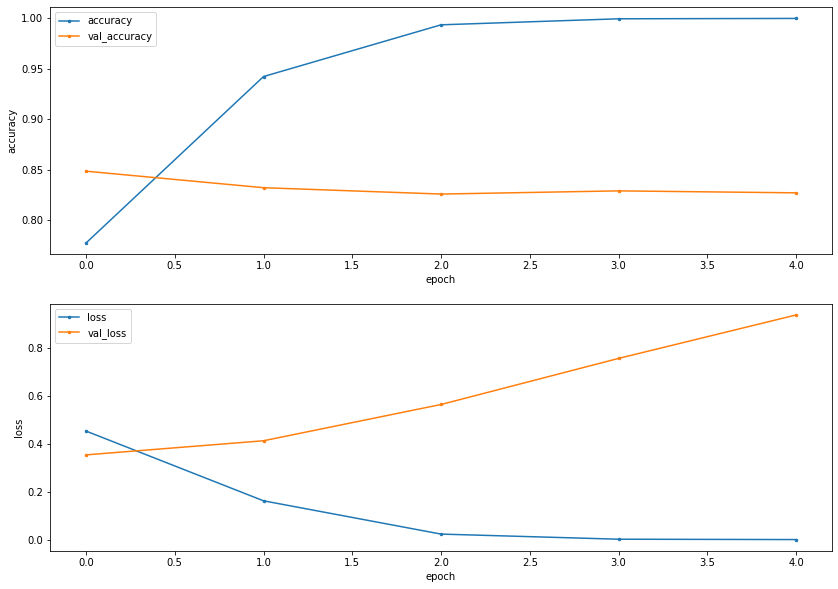

In [25]:
plot_hist()

### <a name='a4'></a> 5. Warstwa SimpleRNN

In [27]:
from tensorflow.keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32))
model.add(SimpleRNN(units=16))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                784       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 320,801
Trainable params: 320,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

In [29]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10,
                    validation_data=(X_val, y_val), verbose=False)

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.643448,0.608358,0.505215,0.772364,0
1,0.396603,0.832060,0.408362,0.828364,1
2,0.269000,0.892418,0.392513,0.834788,2
3,0.186389,0.929731,0.433706,0.841091,3
4,0.121763,0.957612,0.493039,0.813333,4


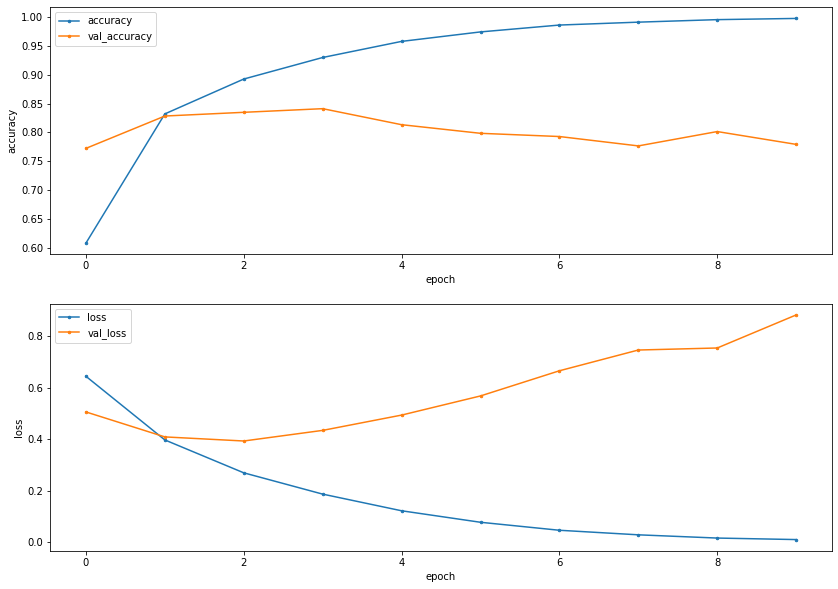

In [31]:
plot_hist()

### <a name='a5'></a> 6. Warstwa LSTM

In [32]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32))
model.add(LSTM(units=16))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

In [34]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10,
                    validation_data=(X_val, y_val), verbose=False)

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.460573,0.776418,0.368128,0.839030,0
1,0.283973,0.887224,0.417035,0.823515,1
2,0.236254,0.909791,0.397532,0.839515,2
3,0.206909,0.921015,0.360647,0.855394,3
4,0.184607,0.933493,0.367384,0.852848,4


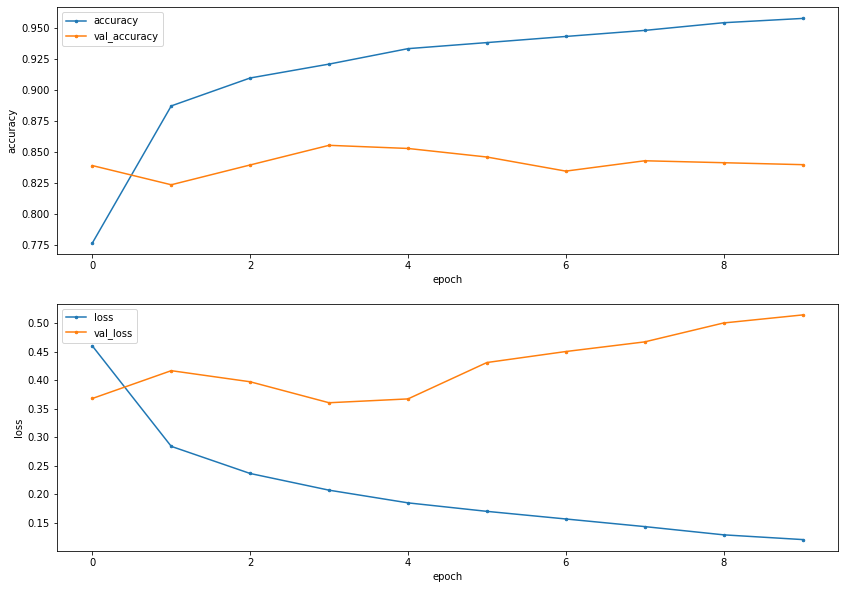

In [36]:
plot_hist()

### <a name='a6'></a> 7. Ocena modelu na zbiorze testowym

In [37]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=32))
model.add(LSTM(units=16))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics='accuracy')

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=3,
                    validation_data=(X_val, y_val), verbose=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [39]:
sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(sequences, maxlen)
test_data.shape

(25000, 100)

In [40]:
test_labels = np.asanyarray(test_labels)
test_labels.shape

(25000,)

In [41]:
model.evaluate(test_data, test_labels)

782/782 [==============================] - 6s 7ms/step - loss: 0.3552 - accuracy: 0.8517


[0.3552199602127075, 0.8517199754714966]